# FilterRegression under $\kappa^3\varepsilon < 1/64$ — richer demos (SoS $\kappa$)

This notebook compares naive OLS vs. robust FilterRegression on a few synthetic cases.
We estimate the clean-data $\kappa$ via the SoS hypercontractivity oracle (whitened) with uniform weights,
choose $\varepsilon$ so $\kappa^3\varepsilon < 1/64$, contaminate only the training split, and evaluate on a held-out test set.

Demos (clean features) and contamination style:
- Gaussian + label spikes (noise violation)
- Gaussian + leverage outliers in X (hypercontractivity violation)
- Ill-conditioned Gaussian + leverage outliers
- Uniform (bounded) + label spikes
- Two-component Gaussian mixture (clean) + leverage outliers

Each demo shows a single PCA(2D) scatter of the training data with:
- point size proportional to the learned Filter weight q_i
- outliers highlighted
- OLS and Filter fitted lines overlaid in the same plot.

Below we also include a compact table and a grouped bar chart with train vs. test MSE for OLS and Filter.

Note: Computing $\kappa$ via SoS requires `cvxpy` to be installed.


In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.linalg import lstsq, svd

from robustgqg import FilterRegression
from robustgqg.regression.hypercontractivity import HyperContractivityOracle

plt.style.use("seaborn-v0_8")
np.random.seed(13)

In [52]:
# --- Small helpers -----------------------------------------------------------
def train_test_split(X, y, test_frac=0.3, seed=0):
    rng = np.random.default_rng(seed)
    n = X.shape[0]
    idx = rng.permutation(n)
    t = int(n * (1 - test_frac))
    return X[idx[:t]], X[idx[t:]], y[idx[:t]], y[idx[t:]]


def mse(y_true, y_pred):
    e = y_true - y_pred
    return float(np.mean(e * e))


def ols_fit(X, y):
    theta, *_ = lstsq(X, y, rcond=None)
    return theta


# Estimate kappa on clean data via SoS (whitened).
def kappa_via_sos(X, solver="SCS", verbose=False):
    n = X.shape[0]
    q = np.full(n, 1.0 / n)
    oracle = HyperContractivityOracle(solver=solver, verbose=verbose)
    F1, _, _ = oracle.run(X, q)
    return float(np.sqrt(max(0.0, F1)))


def sigma_from_clean(X, y, theta_true):
    resid = y - X @ theta_true
    return float(np.std(resid))


# --- Data generators ---------------------------------------------------------
def gen_gaussian(n, d, noise=1.0, seed=0):
    rng = np.random.default_rng(seed)
    X = rng.normal(size=(n, d))
    theta_true = rng.normal(size=d)
    y = X @ theta_true + rng.normal(scale=noise, size=n)
    return X, y, theta_true


def gen_illcond_gaussian(n, d, cond=120.0, noise=0.9, seed=2):
    rng = np.random.default_rng(seed)
    U, _ = np.linalg.qr(rng.normal(size=(d, d)))
    s = np.geomspace(cond, 1.0, num=d)
    A = U @ np.diag(np.sqrt(s)) @ U.T
    X = rng.normal(size=(n, d)) @ A.T
    theta_true = rng.normal(size=d)
    y = X @ theta_true + rng.normal(scale=noise, size=n)
    return X, y, theta_true


def gen_uniform(n, d, noise=1.0, seed=3):
    rng = np.random.default_rng(seed)
    X = (2 * np.sqrt(3)) * (rng.random(size=(n, d)) - 0.5)
    theta_true = rng.normal(size=d)
    y = X @ theta_true + rng.normal(scale=noise, size=n)
    return X, y, theta_true


def gen_mixture_gaussian(n, d, scale_big=2.5, mix=0.5, noise=0.9, seed=4):
    rng = np.random.default_rng(seed)
    z = rng.random(n) < mix
    X = np.empty((n, d))
    X[z] = rng.normal(scale=scale_big, size=(z.sum(), d))
    X[~z] = rng.normal(scale=1.0, size=((~z).sum(), d))
    theta_true = rng.normal(size=d)
    y = X @ theta_true + rng.normal(scale=noise, size=n)
    return X, y, theta_true


# --- Contamination helpers ---------------------------------------------------
def inject_label_outliers(y, eps, magnitude=20.0, seed=42):
    rng = np.random.default_rng(seed)
    n = y.shape[0]
    k = int(np.floor(eps * n))
    if k <= 0:
        return y.copy(), np.array([], dtype=int)
    idx = rng.choice(n, size=k, replace=False)
    y2 = y.copy()
    y2[idx] += rng.choice([-1, 1], size=k) * magnitude
    return y2, idx


def inject_leverage_outliers(X, y, eps, scale=25.0, seed=43):
    rng = np.random.default_rng(seed)
    n, d = X.shape
    k = int(np.floor(eps * n))
    if k <= 0:
        return X.copy(), y.copy(), np.array([], dtype=int)
    idx = rng.choice(n, size=k, replace=False)
    X2 = X.copy()
    X2[idx] = X2[idx] * scale + rng.normal(0, scale, size=(k, d))
    return X2, y.copy(), idx


# --- Simple 2D PCA view of training data -----------------------------------
def pca2_with_projection(X):
    Xc = X - X.mean(axis=0, keepdims=True)
    U, S, Vt = svd(Xc, full_matrices=False)
    V2 = Vt[:2]  # (2, d)
    Z = Xc @ V2.T  # (n, 2)
    return Z, V2


def overlay_model_in_pca(ax, Z, V2, theta, color, label, scale_arrow=1.0):
    # (kept for reference; not used in the unified plot)
    theta_z = V2 @ theta
    v = theta_z / (np.linalg.norm(theta_z) + 1e-12)
    ax.arrow(
        0,
        0,
        scale_arrow * v[0],
        scale_arrow * v[1],
        width=0.02,
        head_width=0.15,
        color=color,
        length_includes_head=True,
        alpha=0.9,
    )
    ax.text(scale_arrow * v[0] * 1.05, scale_arrow * v[1] * 1.05, label, color=color)


def plot_model_line_in_pca(ax, Z, V2, theta, level, color, label, scale_arrow=1.0):
    # Draw the iso-response line {z : (V2@theta)^T z = level}
    theta_z = V2 @ theta
    xs = np.linspace(Z[:, 0].min(), Z[:, 0].max(), 200)
    if abs(theta_z[1]) < 1e-12:
        x0 = level / (theta_z[0] + 1e-12)
        ax.plot(
            [x0, x0],
            [Z[:, 1].min(), Z[:, 1].max()],
            linestyle="--",
            color=color,
            alpha=0.9,
            label=label,
        )
    else:
        ys = (level - theta_z[0] * xs) / theta_z[1]
        ax.plot(xs, ys, linestyle="--", color=color, alpha=0.9, label=label)
    theta_z = V2 @ theta
    v = theta_z / (np.linalg.norm(theta_z) + 1e-12)
    ax.arrow(
        0,
        0,
        scale_arrow * v[0],
        scale_arrow * v[1],
        width=0.02,
        head_width=0.15,
        color=color,
        length_includes_head=True,
        alpha=0.9,
    )
    ax.text(scale_arrow * v[0] * 1.05, scale_arrow * v[1] * 1.05, label, color=color)


# --- One demo ---------------------------------------------------------------
def run_demo(
    name,
    X_clean,
    y_clean,
    theta_true,
    contam,
    magnitude=20.0,
    scale=25.0,
    test_frac=0.3,
    seed=0,
    verbose=False,
):
    # 1) Set thresholds from clean data
    kappa = kappa_via_sos(X_clean, solver="SCS", verbose=verbose)
    sigma = sigma_from_clean(X_clean, y_clean, theta_true)
    eps_max = (1.0 / 64.0) / max(1e-12, kappa**3)
    eps = 0.8 * eps_max

    # 2) Train/test split and contamination on train only
    Xtr0, Xte, ytr0, yte = train_test_split(X_clean, y_clean, test_frac=test_frac, seed=seed)
    if contam == "labels":
        ytr, out_idx = inject_label_outliers(ytr0, eps=eps, magnitude=magnitude, seed=seed + 1)
        Xtr = Xtr0
    elif contam == "leverage":
        Xtr, ytr, out_idx = inject_leverage_outliers(
            Xtr0, ytr0, eps=eps, scale=scale, seed=seed + 1
        )
    else:
        raise ValueError('contam must be "labels" or "leverage"')

    # 3) Fit OLS and Filter
    theta_ols = ols_fit(Xtr, ytr)
    fr = FilterRegression(eps=eps, kappa=kappa, sigma=sigma, verbose=False)
    res = fr.run(Xtr, ytr)

    # 4) Metrics (train/test)
    mse_ols_train = mse(ytr, Xtr @ theta_ols)
    mse_ols_test = mse(yte, Xte @ theta_ols)
    mse_fr_train = mse(ytr, Xtr @ res.theta)
    mse_fr_test = mse(yte, Xte @ res.theta)

    # 5) Visuals: single PCA scatter with weighted points and model lines
    Z, V2 = pca2_with_projection(Xtr)
    fig, ax = plt.subplots(figsize=(7.5, 6))

    # point sizes proportional to filter weights (normalized for visibility)
    q = np.asarray(res.q, dtype=float)
    q = q / (q.max() + 1e-12)
    sizes = 20.0 + 180.0 * q

    if out_idx is not None and len(out_idx) > 0:
        mask = np.ones(Xtr.shape[0], dtype=bool)
        mask[out_idx] = False
        ax.scatter(Z[mask, 0], Z[mask, 1], s=sizes[mask], alpha=0.7, label="Clean")
        ax.scatter(
            Z[out_idx, 0], Z[out_idx, 1], s=sizes[out_idx], alpha=0.9, label="Injected outliers"
        )
    else:
        ax.scatter(Z[:, 0], Z[:, 1], s=sizes, alpha=0.8, label="Samples")

    # Overlay OLS and Filter iso-response lines at the train median(y) level
    level = float(np.median(ytr))
    plot_model_line_in_pca(ax, Z, V2, theta_ols, level, color="tab:green", label="OLS line")
    plot_model_line_in_pca(ax, Z, V2, res.theta, level, color="tab:blue", label="Filter line")

    ax.set_title(f"{name}: PCA(2D) — point size ~ q, with OLS/Filter lines")
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=True)

    plt.tight_layout()
    plt.show()

    return {
        "demo": name,
        "kappa_clean": kappa,
        "eps": eps,
        "mse_ols_train": mse_ols_train,
        "mse_ols_test": mse_ols_test,
        "mse_filter_train": mse_fr_train,
        "mse_filter_test": mse_fr_test,
        "iters": res.iters,
    }

## Run demos

/Users/neil/Documents/Robust estimation via generalized quasi-gradients/robust-estimation/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:173: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


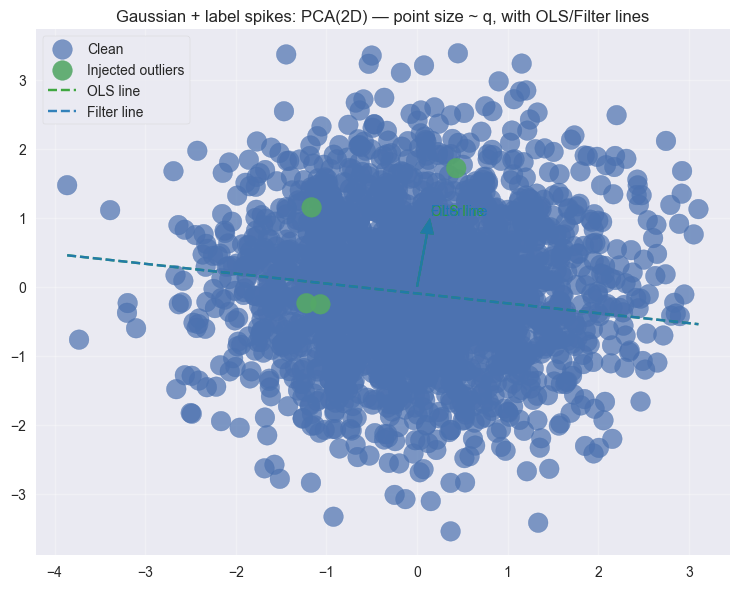

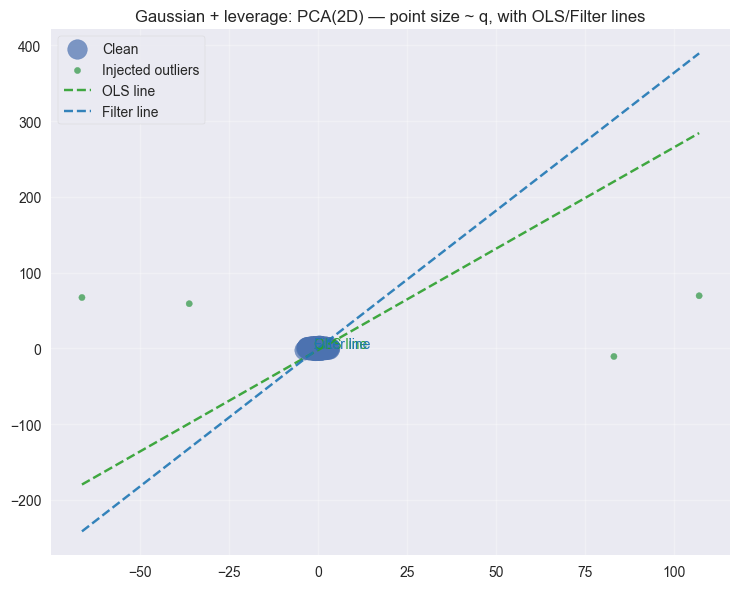

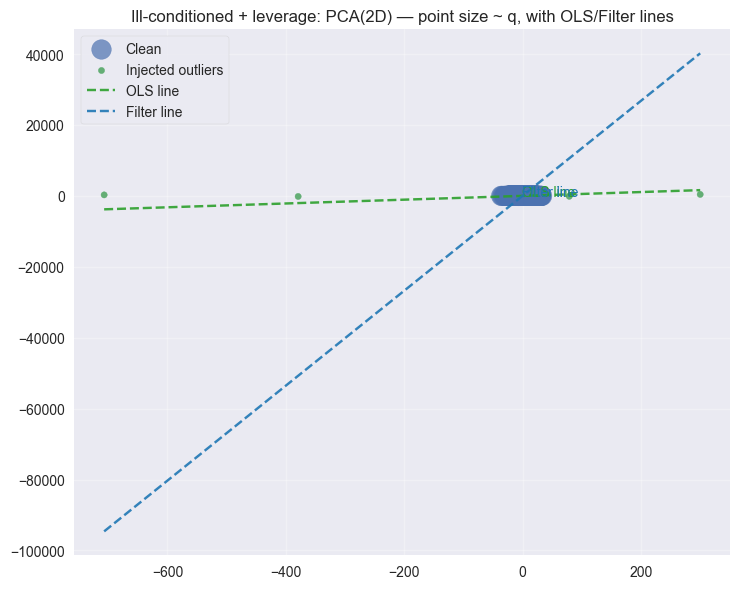

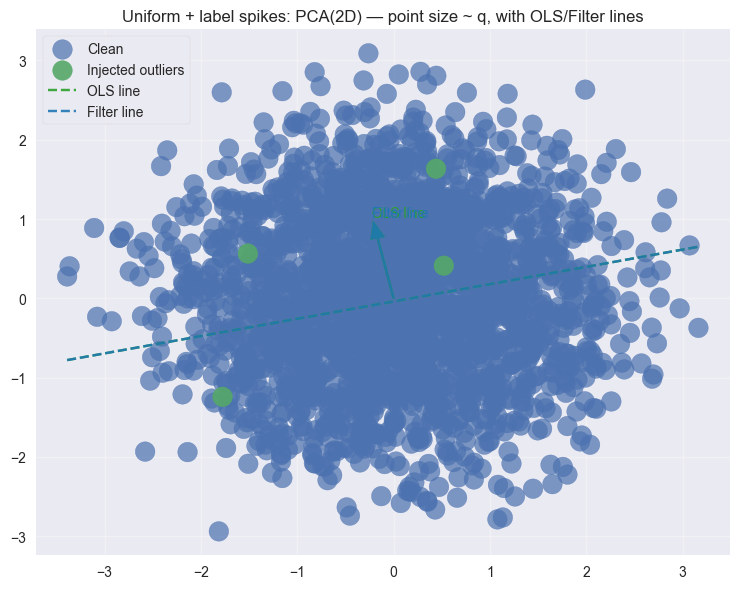

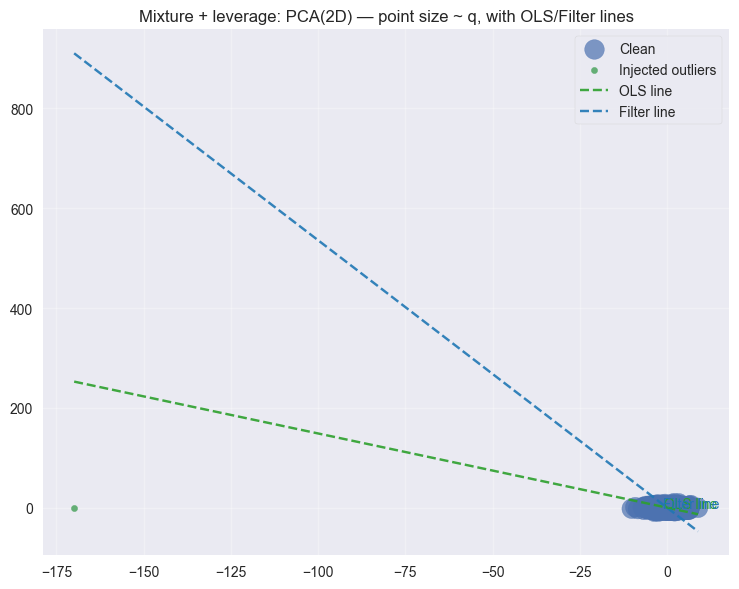

,demo,kappa_clean,eps,mse_ols_train,mse_ols_test,mse_filter_train,mse_filter_test,iters
0,Gaussian + label spikes,1.888219,0.001857,1.695822,1.015798,1.695822,1.015798,0
1,Gaussian + leverage,1.870706,0.001909,3.546166,3.462470,22.473717,1.060554,4
2,Ill-conditioned + leverage,1.876622,0.001891,74.031941,64.230639,471.923771,0.837543,4
3,Uniform + label spikes,1.798589,0.002148,1.580581,1.050212,1.580581,1.050212,0
4,Mixture + leverage,2.412951,0.000890,5.501349,4.035018,21.675372,0.771982,1


In [53]:
results = []
n, d = 3200, 10

# 1) Gaussian + label spikes
X1, y1, th1 = gen_gaussian(n, d, noise=1.0, seed=10)
results.append(
    run_demo("Gaussian + label spikes", X1, y1, th1, contam="labels", magnitude=20.0, seed=11)
)

# 2) Gaussian + leverage outliers
X2, y2, th2 = gen_gaussian(n, d, noise=1.0, seed=20)
results.append(run_demo("Gaussian + leverage", X2, y2, th2, contam="leverage", scale=25.0, seed=21))

# 3) Ill-conditioned Gaussian + leverage
X3, y3, th3 = gen_illcond_gaussian(n, d, cond=120.0, noise=0.9, seed=40)
results.append(
    run_demo("Ill-conditioned + leverage", X3, y3, th3, contam="leverage", scale=22.0, seed=41)
)

# 4) Uniform (bounded) + label spikes
X4, y4, th4 = gen_uniform(n, d, noise=1.0, seed=50)
results.append(
    run_demo("Uniform + label spikes", X4, y4, th4, contam="labels", magnitude=18.0, seed=51)
)

# 5) Gaussian mixture (clean) + leverage
X5, y5, th5 = gen_mixture_gaussian(n, d, scale_big=2.5, mix=0.5, noise=0.9, seed=60)
results.append(run_demo("Mixture + leverage", X5, y5, th5, contam="leverage", scale=22.0, seed=61))

df = pd.DataFrame(results)
df[
    [
        "demo",
        "kappa_clean",
        "eps",
        "mse_ols_train",
        "mse_ols_test",
        "mse_filter_train",
        "mse_filter_test",
        "iters",
    ]
]

## Overall MSE comparison

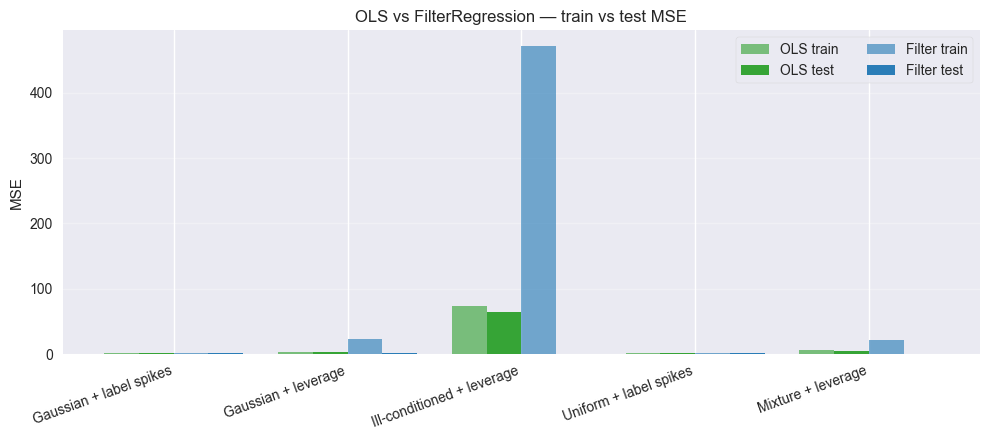

In [54]:
# Grouped bar chart: OLS vs Filter, train vs test
labels = df["demo"].values
x = np.arange(len(labels))
w = 0.2
fig, ax = plt.subplots(figsize=(10, 4.5))
ax.bar(x - 1.5 * w, df["mse_ols_train"], width=w, label="OLS train", color="tab:green", alpha=0.6)
ax.bar(x - 0.5 * w, df["mse_ols_test"], width=w, label="OLS test", color="tab:green", alpha=0.95)
ax.bar(
    x + 0.5 * w, df["mse_filter_train"], width=w, label="Filter train", color="tab:blue", alpha=0.6
)
ax.bar(
    x + 1.5 * w, df["mse_filter_test"], width=w, label="Filter test", color="tab:blue", alpha=0.95
)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=20, ha="right")
ax.set_ylabel("MSE")
ax.set_title("OLS vs FilterRegression — train vs test MSE")
ax.grid(True, axis="y", alpha=0.3)
ax.legend(ncols=2, frameon=True)
plt.tight_layout()
plt.show()